In [3]:
import habitat
import numpy as np
import matplotlib.pyplot as plt
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from PIL import Image
import uuid
import os
import cv2
import shutil
from typing import Any
import quaternion
import random
from env import Env
import matplotlib.colors as mcolors
from habitat.utils.visualizations import maps
from utils import AgentPosition
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
from habitat_sim.utils.common import quat_from_angle_axis
from habitat_sim.agent.agent import AgentState
from habitat import make_dataset
import h5py
import random

ModuleNotFoundError: No module named 'habitat'

In [3]:
def draw_top_down_map(mapp,fogg,cordd, heading, output_size):
    top_down_map = maps.colorize_topdown_map(
        mapp, fogg
    )
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = cordd
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

# Init config

In [6]:
config = habitat.get_config("/data_config/challenge_objectnav2020.local.rgbd.yaml")

config.defrost()

config.DATASET.DATA_PATH = '/data/datasets/objectnav/mp3d/v1/{split}/{split}.json.gz'
config.DATASET.SCENES_DIR = '/data/scene_datasets'
config.DATASET.SPLIT = "train"

config.SIMULATOR.HABITAT_SIM_V0.ALLOW_SLIDING = True
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL = 'GaussianNoiseModel'
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS = habitat.config.default.Config()
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0
config.SIMULATOR.DEPTH_SENSOR.NOISE_MODEL: "RedwoodDepthNoiseModel"
config.SIMULATOR.DEPTH_SENSOR.MAX_DEPTH = 15
config.SIMULATOR.ACTION_SPACE_CONFIG = 'pyrobotnoisy'
config.SIMULATOR.NOISE_MODEL = habitat.config.default.Config()
config.SIMULATOR.NOISE_MODEL.ROBOT = "LoCoBot"
config.SIMULATOR.NOISE_MODEL.CONTROLLER = 'Proportional'   
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.0

H = 320
W = 640

config.SIMULATOR.RGB_SENSOR.HEIGHT = H
config.SIMULATOR.RGB_SENSOR.WIDTH = W
config.SIMULATOR.DEPTH_SENSOR.HEIGHT = H
config.SIMULATOR.DEPTH_SENSOR.WIDTH = W
config.SIMULATOR.SEMANTIC_SENSOR.HEIGHT = H
config.SIMULATOR.SEMANTIC_SENSOR.WIDTH = W

config.PYROBOT.RGB_SENSOR.HEIGHT = H
config.PYROBOT.RGB_SENSOR.WIDTH = W
config.PYROBOT.DEPTH_SENSOR.HEIGHT = H
config.PYROBOT.DEPTH_SENSOR.WIDTH = W

config.SIMULATOR.AGENT_0.SENSORS.append('SEMANTIC_SENSOR')

config.SIMULATOR.TURN_ANGLE = 10
config.SIMULATOR.TILT_ANGLE = 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.25

config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
config.TASK.SENSORS.append("HEADING_SENSOR")
config.TASK.SENSORS.append("GPS_SENSOR")
config.TASK.GPS_SENSOR.DIMENSIONALITY = 2
config.TASK.GPS_SENSOR.GOAL_FORMAT = "CARTESIAN"

config.TASK.AGENT_POSITION_SENSOR = habitat.Config()
config.TASK.AGENT_POSITION_SENSOR.TYPE = "my_supercool_sensor"
config.TASK.AGENT_POSITION_SENSOR.ANSWER_TO_LIFE = 42
config.TASK.SENSORS.append("AGENT_POSITION_SENSOR")

config.ENVIRONMENT.MAX_EPISODE_STEPS = 350
config.TASK.TOP_DOWN_MAP.MAX_EPISODE_STEPS = 350

config.freeze()

In [7]:
dataset = make_dataset(config.DATASET.TYPE)
scenes = config.DATASET.CONTENT_SCENES
if "*" in config.DATASET.CONTENT_SCENES:
    scenes = dataset.get_scenes_to_load(config.DATASET)
scenes = ['17DRP5sb8fy','1LXtFkjw3qL','1pXnuDYAj8r','29hnd4uzFmX',
         '5LpN3gDmAk7','5q7pvUzZiYa','759xd9YjKW5','7y3sRwLe3Va',
         '82sE5b5pLXE','8WUmhLawc2A','B6ByNegPMKs','D7G3Y4RVNrH',
         'D7N2EKCX4Sj','E9uDoFAP3SH','EDJbREhghzL','GdvgFV5R1Z5',
         'HxpKQynjfin','JF19kD82Mey','JeFG25nYj2p','PX4nDJXEHrG',
         'Pm6F8kyY3z2','PuKPg4mmafe','S9hNv5qa7GM','ULsKaCPVFJR',
         'Uxmj2M2itWa','V2XKFyX4ASd','VFuaQ6m2Qom','VLzqgDo317F',
         'VVfe2KiqLaN','Vvot9Ly1tCj','XcA2TqTSSAj','YmJkqBEsHnH',
         'ZMojNkEp431','aayBHfsNo7d','ac26ZMwG7aT','b8cTxDM8gDG',
         'cV4RVeZvu5T','dhjEzFoUFzH','e9zR4mvMWw7','i5noydFURQK',
         'jh4fc5c5qoQ','kEZ7cmS4wCh','mJXqzFtmKg4','p5wJjkQkbXX',
         'pRbA3pwrgk9','qoiz87JEwZ2','r1Q1Z4BcV1o','r47D5H71a5s',
         'rPc6DW4iMge','s8pcmisQ38h','sKLMLpTHeUy','sT4fr6TAbpF',
         'uNb9QFRL6hY','ur6pFq6Qu1A','vyrNrziPKCB'] 

with_chairs_start = [40909,77965,117321,148663,200080,258801,
308203,353298,391478,457463,503401,549169,591477,
653545,702887,754494,798177,850480,898638,931038,
1000393,1033914,1085846,1119654,1159294,1220359,1242788,
1306119,1367108,1403388,1442783,1497270,1511322,1568728,
1600209,1658016,1710302,1755402,1810457,1846223,1886431,
1931681,1962766,2012767,2077367,2118319,2172627,2225363,
2237215,2282635,2338963,2415591,2444549,2494042,2543961]

with_chairs_end = [49242,87711,119554,163663,208463,265768,
317231,362692,397506,464266,523947,587631,602808,
674522,710798,760621,811034,856036,909838,936477,
1008458,1035140,1090882,1131261,1174343,1228770,1255461,
1332415,1372513,1412100,1455878,1500211,1536108,1574901,
1607573,1665333,1716850,1762671,1818149,1855369,1887770,
1939453,1972207,2023441,2080907,2131414,2178826,2228090,
2245612,2298176,2351655,2426977,2452421,2504957,2550532]

norm_karts_index = [40909,
40910,40911,40912,40913,117321,
117322,117323,117324,117325,148663,
148666,200080,200082,200083,258801,
258803,258805,353298,391478,391480,
391482,457463,457464,457465,457466,
457467,503401,503404,591477,591478,
591479,591480,591481,653545,653546,
653547,653548,653549,702887,702889,
702890,702891,754494,754495,754496,
754497,754498,798177,798178,798179,
798180,798181,850480,850481,850482,
850483,898638,898639,898640,898641,
898642,931038,931040,1000393,1000394,
1000395,1000396,1000397,1033914,1033915,
1033916,1085849,1085850,1119654,1220359,
1220361,1242788,1242790,1242791,1242792,
1306120,1306121,1306122,1306123,1367108,
1367109,1367110,1403389,1403390,1403391,
1442783,1442786,1511322,1511323,1511324,
1511325,1511326,1568728,1568729,1568730,
1568731,1568732,1600209,1600210,1600211,
1600212,1658016,1658019,1658020,1710302,
1710303,1710306,1810458,1846223,1846224,
1846225,1846226,1846227,1886431,1886432,
1931681,1931684,1931685,1962766,1962767,
1962768,1962769,1962770,2012767,2077367,
2077369,2118319,2172627,2172628,2172629,
2172630,2172631,2225363,2225364,2225365,
2225366,2225367,2237215,2237217,2237218,
2237219,2282635,2282637,2282638,2338963,
2415591,2415592,2415593,2415594,2415595,
2444549,2444551,2444552,2494042,2494044,
2494046,2543961,2543962,2543963,2543965]

number_goals = [11 ,23 ,52 ,9 ,28 ,17 ,39 ,31 ,17 ,20 ,143 ,20 ,63 ,73 ,25 ,6 ,
9 ,6 ,28 ,26 ,5 ,134 ,14 ,26 ,31 ,18 ,55 ,71 ,8 ,23 ,22 ,2 ,58 ,20 ,38 ,30 ,
11 ,24 ,22 ,15 ,18 ,30 ,27 ,38 ,8 ,33 ,162 ,3 ,22 ,23 ,33 ,23 ,37 ,31 ,41]

eps = np.concatenate([[ii for ii in range(with_chairs_start[i],with_chairs_end[i])][:5] for i in range(len(with_chairs_start))])


config.defrost()
config.DATASET.CONTENT_SCENES = scenes
config.freeze()

2020-09-10 10:48:57,726 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1


# Run Env

In [8]:
env = Env(config)

2020-09-10 10:48:58,312 Initializing dataset ObjectNav-v1
Initializing dataset ObjectNav-v1
2020-09-10 10:55:10,164 initializing sim Sim-v0
initializing sim Sim-v0
2020-09-10 10:55:18,240 Initializing task ObjectNav-v1
Initializing task ObjectNav-v1
The answer to life is 42


In [10]:
inputs = open('episode_filepath.txt','w')
for iii in norm_karts_index:
    observations, info, done = env.reset(iii)
    inputs.write(str(iii)+'\t'+env._current_episode.scene_id+'\n')
    
inputs.close()    

In [ ]:
last_gls = set([])
with_chairs_start = []
with_chairs_end = []
for i in range(len(env._episode_iterator.episodes)):
    gls = []
    for ii in env._episode_iterator.episodes[i].goals:
        gls.append(ii.object_category)
    
    if last_gls != set(gls):
        print(i,set(gls)) 
        if list(gls)[0] == 'chair':
            with_chairs_start.append(i)
        if list(last_gls) != []:    
            if list(last_gls)[0] == 'chair':
                with_chairs_end.append(i)    
        
    last_gls = set(gls) 

In [48]:
i = 931038
print(env._episode_iterator.episodes[i].scene_id)
print(env._episode_iterator.episodes[i].start_position)
gls = []
for ii in env._episode_iterator.episodes[i].goals:
    gls.append(ii.object_category)
gls    

/data/scene_datasets/mp3d/PX4nDJXEHrG/PX4nDJXEHrG.glb
[-10.1093, -2.058, -4.21809]


['chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair',
 'chair']

In [29]:
mapps1 = []
norm_karts = []
norm_karts_index = []
for i in eps:
    print(i)
    observations, info, done = env.reset(i)
    while not done:
        observations, info, done = env.step(2,ideal_action=True)
    topdown_map = draw_top_down_map(info['top_down_map']['map'],info['top_down_map']['fog_of_war_mask'],info['top_down_map']['agent_map_coord'],observations['heading'][0],observations['rgb'].shape[0])
    mapps1.append(topdown_map)
    if info['success']>0.8:
        norm_karts.append(topdown_map)
        norm_karts_index.append(i)    

40909
40910
40911
40912
40913
77965
77966
77967
77968
77969
117321
117322
117323
117324
117325
148663
148664
148665
148666
148667
200080
200081
200082
200083
200084
258801
258802
258803
258804
258805
308203
308204
308205
308206
308207
353298
353299
353300
353301
353302
391478
391479
391480
391481
391482
457463
457464
457465
457466
457467
503401
503402
503403
503404
503405
549169
549170
549171
549172
549173
591477
591478
591479
591480
591481
653545
653546
653547
653548
653549
702887
702888
702889
702890
702891
754494
754495
754496
754497
754498
798177
798178
798179
798180
798181
850480
850481
850482
850483
850484
898638
898639
898640
898641
898642
931038
931039
931040
931041
931042
1000393
1000394
1000395
1000396
1000397
1033914
1033915
1033916
1033917
1033918
1085846
1085847
1085848
1085849
1085850
1119654
1119655
1119656
1119657
1119658
1159294
1159295
1159296
1159297
1159298
1220359
1220360
1220361
1220362
1220363
1242788
1242789
1242790
1242791
1242792
1306119
1306120
1306121
130612

In [30]:
for ii,i in enumerate(norm_karts):
    plt.imsave('/root/RND/test_images2/{}.png'.format(100000+ii),i)

In [9]:
mapps1 = []
norm_karts_index2 = []
for iii in norm_karts_index:
    rgb = []
    depth = []
    semantic = []
    objectgoal = []
    compass = []
    gps = []
    position = []
    rotation = []
    heading = []
    top_down_map = []
    fog_of_war_mask = []
    agent_map_coord = []
    agent_angle = []
    mapping = None
    index_to_title_map = None
    print(iii)
    i = 0
    observations, info, done = env.reset(iii)
    
    while not done:
        i+=1
        observations, info, done = env.step(2,ideal_action=True)
        scene = env.sim.semantic_annotations()
        instance_id_to_label_id = {int(obj.id.split("_")[-1]): obj.category.index() for obj in scene.objects}
        mapping_ = np.array([ instance_id_to_label_id[i] for i in range(len(instance_id_to_label_id)) ])
        index_to_title_map_ = {obj.category.index(): obj.category.name() for obj in scene.objects }


        rgb.append(observations['rgb'])
        depth.append(observations['depth'])
        semantic.append(observations['semantic'])
        objectgoal.append(observations['objectgoal'])
        compass.append(observations['compass'])
        gps.append(observations['gps'])
        position.append(env._sim.get_agent_state(0).position)
        rotation.append(np.array([env._sim.get_agent_state(0).rotation.w,env._sim.get_agent_state(0).rotation.x,env._sim.get_agent_state(0).rotation.y,env._sim.get_agent_state(0).rotation.z]))
        heading.append(observations['heading'])
        top_down_map.append(info['top_down_map']['map'])
        fog_of_war_mask.append(info['top_down_map']['fog_of_war_mask'])
        agent_map_coord.append(info['top_down_map']['agent_map_coord'])
        agent_angle.append(info['top_down_map']['agent_angle'])
        mapping = mapping_
        index_to_title_map = str(index_to_title_map_)
        
    if info['success']>0.8:
        name = '/root/RND/dataset_hdf5/done_{}_{}_{}_{}_{}.hdf5'.format(int(config.SIMULATOR.TURN_ANGLE),int(config.SIMULATOR.FORWARD_STEP_SIZE*100),int(config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER*100),int(config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant*100),iii)
        name2 = '/root/RND/test_images2/done_{}_{}_{}_{}_{}.png'.format(int(config.SIMULATOR.TURN_ANGLE),int(config.SIMULATOR.FORWARD_STEP_SIZE*100),int(config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER*100),int(config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant*100),iii)
    else:
        name = '/root/RND/dataset_hdf5/failed_{}_{}_{}_{}_{}.hdf5'.format(int(config.SIMULATOR.TURN_ANGLE),int(config.SIMULATOR.FORWARD_STEP_SIZE*100),int(config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER*100),int(config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant*100),iii)
        name2 = '/root/RND/test_images2/failed_{}_{}_{}_{}_{}.png'.format(int(config.SIMULATOR.TURN_ANGLE),int(config.SIMULATOR.FORWARD_STEP_SIZE*100),int(config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER*100),int(config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant*100),iii)
        
    norm_karts_index2.append(iii)
    topdown_map = draw_top_down_map(info['top_down_map']['map'],info['top_down_map']['fog_of_war_mask'],info['top_down_map']['agent_map_coord'],observations['heading'][0],observations['rgb'].shape[0])
    plt.imsave(name2,topdown_map)
    mapps1.append(topdown_map)

    with h5py.File(name, 'w') as f:
        f.create_dataset("rgb", data=np.array(rgb))
        f.create_dataset("depth", data=np.array(depth))
        f.create_dataset("semantic", data=np.array(semantic))
        f.create_dataset("objectgoal", data=np.array(objectgoal))
        f.create_dataset("compass", data=np.array(compass))
        f.create_dataset("gps", data=np.array(gps))
        f.create_dataset("position", data=np.array(position))
        f.create_dataset("rotation", data=np.array(rotation))
        f.create_dataset("heading", data=np.array(heading))
        f.create_dataset("top_down_map", data=np.array(top_down_map))
        f.create_dataset("fog_of_war_mask", data=np.array(fog_of_war_mask))
        f.create_dataset("agent_map_coord", data=np.array(agent_map_coord))
        f.create_dataset("agent_angle", data=np.array(agent_angle))
        f.create_dataset("mapping", data=np.array(mapping))
        f.create_dataset("index_to_title_map", data=np.string_(index_to_title_map)) 
    
    
    break

40909


## Reset (number in brackets is the number of episode, if none, random scene will be initialized)

In [14]:
observations, info, done = env.reset(1)

## Run scene until done (action 0 - done episode, action 1 - step forward, action 2,3 - left/right turn)
## if ideal_action=True ideal action to achieve goal will perform

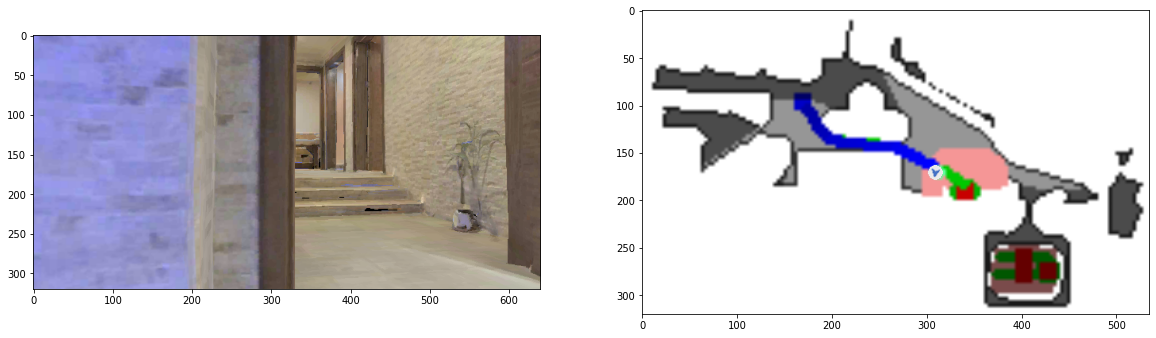

In [15]:
rgbs = []
depths = []
mapss = []
while not done:
    observations, info, done = env.step(2,ideal_action=True)
    rgbs.append(observations['rgb'])
    depths.append(observations['depth'])
    topdown_map = draw_top_down_map(info['top_down_map']['map'],info['top_down_map']['fog_of_war_mask'],info['top_down_map']['agent_map_coord'],observations['heading'][0],observations['rgb'].shape[0])
    mapss.append(topdown_map)
topdown_map = draw_top_down_map(info['top_down_map']['map'],info['top_down_map']['fog_of_war_mask'],info['top_down_map']['agent_map_coord'],observations['heading'][0],observations['rgb'].shape[0])
plt.rcParams["figure.figsize"] = (20,6)
plt.subplot(1,2,1)
plt.imshow(observations['rgb'])
plt.subplot(1,2,2)
plt.imshow(topdown_map)

In [16]:
!rm -r /root/RND/test_image/
!mkdir /root/RND/test_image/

In [17]:
for ii in range(len(rgbs)):
    plt.imsave('/root/RND/test_image/{}.png'.format(1000+ii),np.hstack((np.hstack((rgbs[ii],np.stack([(depths[ii]*255).astype('uint8') for i in range(3)],2)[:,:,:,0])),mapss[ii][:,:534,:])))

In [18]:
!ffmpeg -framerate 20 -pattern_type glob -i '/root/RND/test_image/*.png' -c:v libx264 -r 20 -pix_fmt yuv420p /root/RND/out.mp4 -y

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

## Set random position at current episode

In [10]:
initial_state = AgentState()
initial_state.position = env._sim._sim.pathfinder.get_random_navigable_point()
initial_state.rotation = quat_from_angle_axis(random.uniform(0, 2.0 * np.pi), np.array([0, 1, 0]))
env._sim._sim.agents[0].set_state(initial_state, is_initial=False)
env._reset_stats()

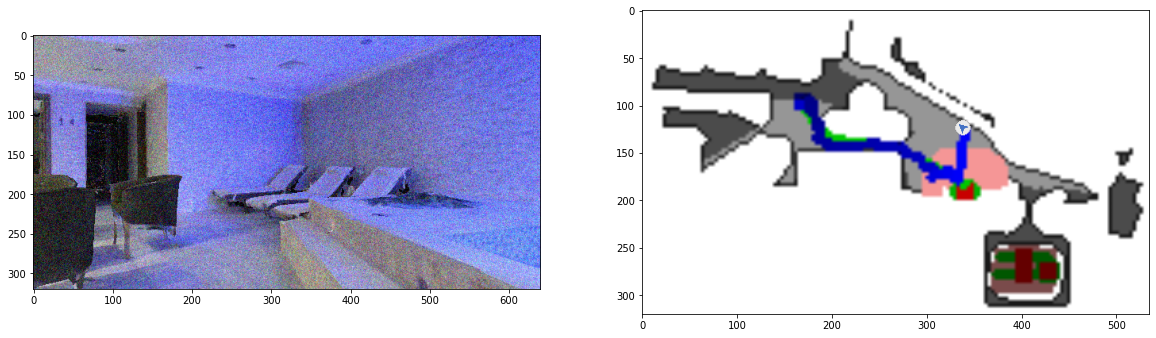

In [11]:
observations, info, done = env.step(2,ideal_action=True)
topdown_map = draw_top_down_map(info['top_down_map']['map'],info['top_down_map']['fog_of_war_mask'],info['top_down_map']['agent_map_coord'],observations['heading'][0],observations['rgb'].shape[0])
plt.rcParams["figure.figsize"] = (20,6)
plt.subplot(1,2,1)
plt.imshow(observations['rgb'])
plt.subplot(1,2,2)
plt.imshow(topdown_map)